# Data Analysis for Gamma Spectroscopy

Adrian Fisher, Kirsten Weidner, Ryan "Garrett" Arquette

We are in this notebook using the relationship between data taken using a scintillator and a photomultiplier tube to discover the nature of an unknown radioactive element. The objective is to use the data from known elements with known gamma decay energies to create a linear relationship with the device's data, calibrating it to find new ones.

Using the equation of a line:
$$y = mx + b$$

The relationship between the times an energy channel was struck, $C$, and the slope and intercept of the known energy levels, $E$, becomes:
$$C = mE + b$$

Gathering data on $C$, and using it to put error bars on $b$ and $m$, means that we can find $E$ within a margin of error.

# Gathering Data

We started by running USX software to gather data on known radiation sources which release gamma rays at energy levels that span the range of the unknown source.

## Software Settings

Using the scintillator and photomultiplier tube devices, we are able to gather data through the provided USX software. After opening the software, we changed the settings to match those below:

* Acquisition Mode: PHA Pre-Amp
* High Voltage: 700
* Conversion Gain: 2048
* Coarse Gain: 2
* Fine Gain: 1.09
* Upper Discriminator: 2096
* Lower Discriminator: 27

## General Procedure

We then placed the radiation sources in the slots beneath the scintillator and started a run. After approximately 5 minutes, the data was fully collected and visible peaks emerged. 

We stopped the run and saved the data to a .csv file which was named to match the source (such as Co60 01.csv for Cobalt-60, our first test). 

The general procedure was first practiced with Cobalt-60 before being generalized and done for each of our collected data samples.

Adrian, Kirsten, Garrett 2024-10-02 01:56:59 

Cobalt-60 has peak wavelengths at 1.175 & 1.333 MeV


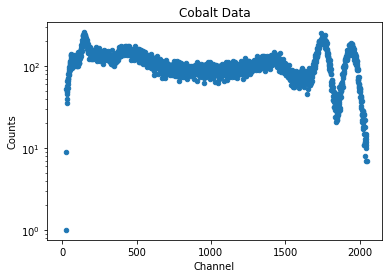

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime

# Create a time stamp for each run
my_name = "Adrian, Kirsten, Garrett"
time_stamp_format = "%Y-%m-%d %H:%M:%S"
print(my_name, datetime.datetime.now().strftime(time_stamp_format),'\n')

cobalt = pd.read_csv("CalCo60 01Ga.csv", skiprows = 21, usecols = [0, 2])

print("Cobalt-60 has peak wavelengths at 1.175 & 1.333 MeV")

ax2 = cobalt.plot.scatter(x = cobalt.columns[0], y = cobalt.columns[1])
ax2.set_title("Cobalt Data")
plt.yscale('log')
plt.savefig('cobalt data.png', format='png')

plt.show()

# Describing the shape of the data

A gaussian curve can be described by four variables:

$A:$ The ampltidue of the curve. This corresponds to the overall number of times a region on the detector was struck,

$B:$ The mean channel number, also $\mu$. This corresponds to the center of the curve,

$C:$ The standard deviation/width of the gaussian plot, also $\sigma$. This corresponds to the uncertainty in our data.

$D:$ And, the height above the $y$ axis, or the y offset

### Equation of a Gaussian Fit: $$f(x) = A e^{-} \frac{(x-B)^2}{2C^2} + D$$

### Equation for multiple Gaussian Fits: $$f(x) = A_{1} e^{-} \frac{(x-B_{1})^2}{2C_{1}^{2}} + A_{2} e^{-} \frac{(x-B_{2})^2}{2C_{2}^{2}} + ... + D$$


### Coding the equations:

In the code to find the equations of the gaussian line, we utilize the python library scipy to do much of the heavy lifting of linear algebra and linear regression.

In [6]:
from scipy.stats import linregress, norm
from scipy.optimize import curve_fit

# Defining the gaussian for one and two curves
def gaussian(x, amplitude, mu, sigma, y_offset):
    return amplitude * np.exp(-((x - mu)**2) / (2 * sigma**2)) + y_offset

def gaussian2(x, amp1, amp2, mu1, mu2, sigma1, sigma2, y_offset):
    return (amp1 * np.exp(-((x - mu1) ** 2) / (2 * sigma1 ** 2)
                         + amp2 * np.exp(-((x - mu2) ** 2) / (2 * sigma2 ** 2)) + y_offset))

# Using estimates for the gaussian values and the data gathered in the experiment, 
# curve_fit gives us the optimized parameters and the associated covariance matrix
def find_values(A, B, C, D, xdata, ydata):
    # popt = parameters optimized
    # pcov = Covariance, variance = error squared
    popt, pcov = curve_fit(gaussian, xdata, ydata, 
                          p0=[A, B, C, D]) 

    amplitude, mean, sigma, vertical_offset = popt
    sigma_amp, sigma_mean, sigma_std, sigma_b = np.sqrt(np.diag(pcov))
    
    # Function automatically plots the data
    plt.scatter(xdata, ydata, label="Data", marker='.')
    plt.plot(xdata, gaussian(xdata, *popt), label="Best Fit", color="red")
    #plt.yscale('log')
    
    
    print()
    
    # Function automatically prints the gathered values for the data
    print("Optimized Parameters:")
    print("[Amplitude, Mean, Sigma, Vertical Offset]")
    print(f"Amplitude: {amplitude:.2f}, Mean: {mean:.2f}, Sigma: {sigma:.2f}, y_offset: {vertical_offset:.2f}")
    print()
    print(f"Uncertainty in amplitude: {sigma_amp:.2f}, Uncertainty in mean: {sigma_mean:.2f}")
    print(f"Sigma standard deviation: {sigma_std:.2f}, Uncertainty in y offset: {sigma_b:.2f}")
    
    return amplitude, mean, sigma, vertical_offset, sigma_amp, sigma_mean, sigma_std, sigma_b


def find_uncertainties(values):
    sigma_amp, sigma_mean, sigma_std, sigma_b = values[4:]
    return sigma_amp, sigma_mean, sigma_std, sigma_b

# Isolating the Peaks

Each peak of the data is isolated and assigned to a variable so that a gaussian curve can be fit to it. 

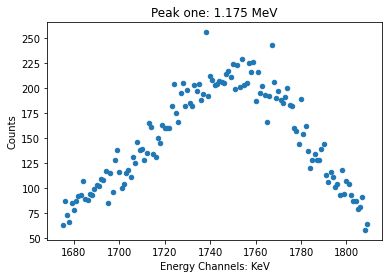

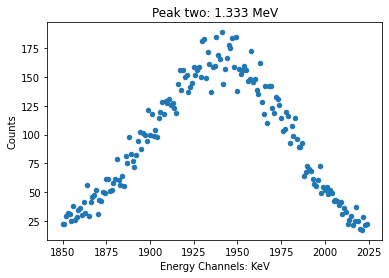

In [7]:
cobalt_peak_1 = cobalt.iloc[1675:1810].copy()
ax1 = cobalt_peak_1.plot.scatter(cobalt_peak_1.columns[0], cobalt_peak_1.columns[1])
ax1.set_title("Peak one: 1.175 MeV")
ax1.set_xlabel("Energy Channels: KeV")

cobalt_peak_2 = cobalt.iloc[1850:2025].copy()
ax2 = cobalt_peak_2.plot.scatter(cobalt_peak_2.columns[0], cobalt_peak_2.columns[1])
ax2.set_title("Peak two: 1.333 MeV")
ax2.set_xlabel("Energy Channels: KeV")

plt.show()

# Applying the function to the data

Estimates for the four values of the data's gaussian curve was done by visually inspecting the data after isolating the peaks. Our estimates and the isolated data were applied in the function to generate gaussian curves which also fit the data. 


Optimized Parameters:
[Amplitude, Mean, Sigma, Vertical Offset]
Amplitude: 150.64, Mean: 1748.19, Sigma: 31.16, y_offset: 65.56

Uncertainty in amplitude: 6.28, Uncertainty in mean: 0.57
Sigma standard deviation: 1.61, Uncertainty in y offset: 6.81

Optimized Parameters:
[Amplitude, Mean, Sigma, Vertical Offset]
Amplitude: 156.96, Mean: 1939.07, Sigma: 39.02, y_offset: 9.62

Uncertainty in amplitude: 3.83, Uncertainty in mean: 0.43
Sigma standard deviation: 1.22, Uncertainty in y offset: 4.18


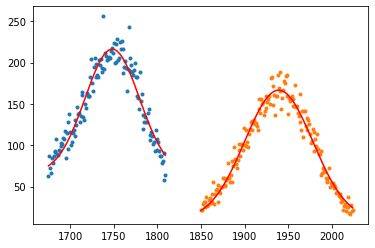

In [8]:
A = 175  #amplitude
B = 1755 #mu
C = 20   #sigma
D = 50  #vertical_offset
xdata = cobalt_peak_1.iloc[:, 0].values
ydata = cobalt_peak_1.iloc[:, 1].values

cobalt_peak_1_values = find_values(A, B, C, D, xdata, ydata)

sigma_amp, sigma_mean, sigma_std, sigma_b = find_uncertainties(cobalt_peak_1_values)

A = 150
B = 1940
C = 30
D = 25

xdata = cobalt_peak_2.iloc[:,0].values
ydata = cobalt_peak_2.iloc[:, 1].values

cobalt_peak_2_values = find_values(A, B, C, D, xdata, ydata)

sigma_amp, sigma_mean, sigma_std, sigma_b = find_uncertainties(cobalt_peak_2_values)

# Repeating this process

Now that we have a general idea of what to do, we can apply this method to the rest of our data. First, we load the rest of the total data and assign them to variables. From there, the data is plotted and visually inspected.

Sodium-22 has known peaks at 0.511 & 1.2745 MeV
Cadmium 109 has a known peak at 0.0088 MeV
Cobalt-57 has a known peak at 0.122 MeV
Manganese-54 has a peak at 0.835 MeV
Barium-133 has peaks 0.081, 0.276, 0.303, 0.356, & 0.384 MeV


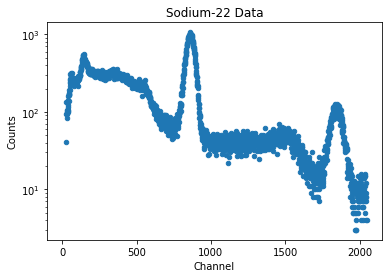

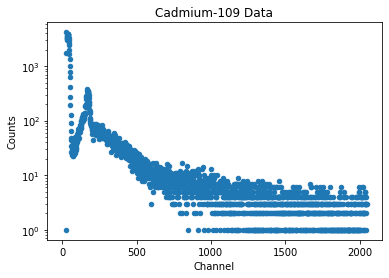

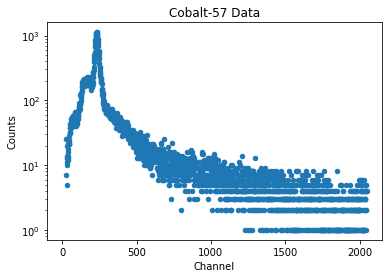

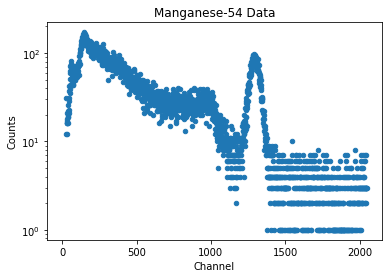

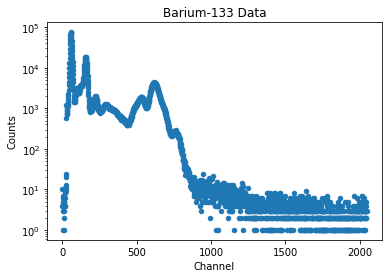

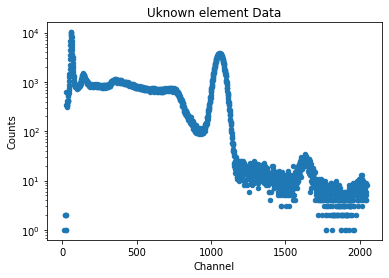

In [9]:
sodium      = pd.read_csv("CalNa22 02Ga.csv", skiprows = 21, usecols = [0, 2])
cadmium     = pd.read_csv("CalCd109 03Ga.csv", skiprows = 21, usecols = [0, 2])
cobalt57    = pd.read_csv("Co57 04Ga.csv", skiprows = 21, usecols = [0, 2])
manganese   = pd.read_csv("Mn54 05Ga.csv", skiprows = 21, usecols = [0, 2])
barium      = pd.read_csv("Ba133 06Ga.csv", skiprows = 21, usecols = [0, 2])
unknown     = pd.read_csv("Unknown 7.csv", skiprows = 21, usecols = [0, 2])

print("Sodium-22 has known peaks at 0.511 & 1.2745 MeV")
print("Cadmium 109 has a known peak at 0.0088 MeV")
print("Cobalt-57 has a known peak at 0.122 MeV")
print("Manganese-54 has a peak at 0.835 MeV")
print("Barium-133 has peaks 0.081, 0.276, 0.303, 0.356, & 0.384 MeV")

Na_plot = sodium.plot.scatter(sodium.columns[0], sodium.columns[1])
Na_plot.set_title("Sodium-22 Data")
plt.yscale('log')

Cd_plot = cadmium.plot.scatter(cadmium.columns[0], cadmium.columns[1])
Cd_plot.set_title("Cadmium-109 Data")
plt.yscale('log')

Co57_plot = cobalt57.plot.scatter(cobalt57.columns[0], cobalt57.columns[1])
Co57_plot.set_title("Cobalt-57 Data")
plt.yscale('log')

Mn_plot = manganese.plot.scatter(manganese.columns[0], manganese.columns[1])
Mn_plot.set_title("Manganese-54 Data")
plt.yscale('log')

Ba_plot = barium.plot.scatter(barium.columns[0], barium.columns[1])
Ba_plot.set_title("Barium-133 Data")
plt.yscale('log')

unk_plot = unknown.plot.scatter(unknown.columns[0], unknown.columns[1])
unk_plot.set_title("Uknown element Data")

plt.yscale('log')
plt.show()


Optimized Parameters:
[Amplitude, Mean, Sigma, Vertical Offset]
Amplitude: 938.31, Mean: 860.33, Sigma: 26.56, y_offset: 54.79

Uncertainty in amplitude: 9.86, Uncertainty in mean: 0.15
Sigma standard deviation: 0.38, Uncertainty in y offset: 10.64

Optimized Parameters:
[Amplitude, Mean, Sigma, Vertical Offset]
Amplitude: 101.46, Mean: 1842.52, Sigma: 36.31, y_offset: 11.88

Uncertainty in amplitude: 1.82, Uncertainty in mean: 0.51
Sigma standard deviation: 0.95, Uncertainty in y offset: 1.75


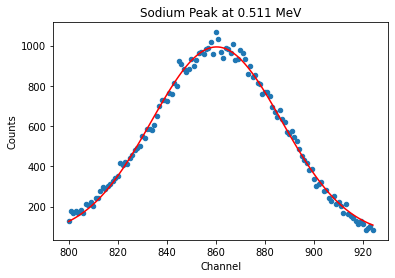

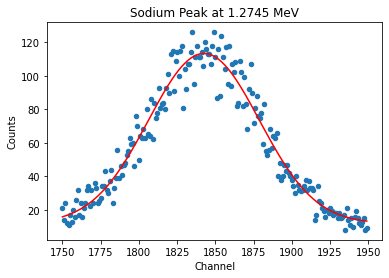

In [12]:
A = 800
B = 860
C = 20
D = 200

sodium_peak_1 = sodium.iloc[800:925].copy()
ax1 = sodium_peak_1.plot.scatter(sodium_peak_1.columns[0], sodium_peak_1.columns[1])
ax1.set_title("Sodium Peak at 0.511 MeV")

xdata_Na = sodium_peak_1.iloc[:,0].values
ydata_Na = sodium_peak_1.iloc[:,1].values

sodium_peak_1_values = find_values(A, B, C, D, xdata_Na, ydata_Na)

sigma_amp, sigma_mean, sigma_std, sigma_b = find_uncertainties(sodium_peak_1_values)

sodium_peak_2 = sodium.iloc[1750:1950].copy()
ax2 = sodium_peak_2.plot.scatter(sodium_peak_2.columns[0], sodium_peak_2.columns[1])
ax2.set_title("Sodium Peak at 1.2745 MeV")

A = 100
B = 1860
C = 30
D = 20

xdata_Na = sodium_peak_2.iloc[:,0].values
ydata_Na = sodium_peak_2.iloc[:,1].values

sodium_peak_2_values = find_values(A, B, C, D, xdata_Na, ydata_Na)

sigma_amp, sigma_mean, sigma_std, sigma_b = find_uncertainties(sodium_peak_2_values)


Optimized Parameters:
[Amplitude, Mean, Sigma, Vertical Offset]
Amplitude: 4328.13, Mean: 37.48, Sigma: 7.99, y_offset: -221.32

Uncertainty in amplitude: 235.04, Uncertainty in mean: 0.37
Sigma standard deviation: 0.60, Uncertainty in y offset: 203.90


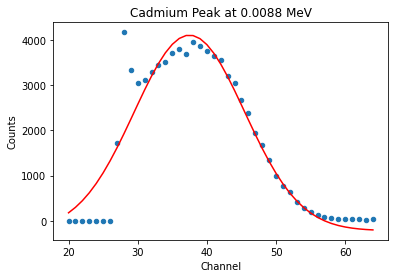

In [14]:
A = 4000
B = 40
C = 10
D = 0

cadmium_peak_1 = cadmium.iloc[20:65].copy()
ax1 = cadmium_peak_1.plot.scatter(cadmium_peak_1.columns[0], cadmium_peak_1.columns[1])
ax1.set_title("Cadmium Peak at 0.0088 MeV")

xdata_Ca = cadmium_peak_1.iloc[:,0].values
ydata_Ca = cadmium_peak_1.iloc[:,1].values

cadmium_peak_1_values = find_values(A, B, C, D, xdata_Ca, ydata_Ca)

sigma_amp, sigma_mean, sigma_std, sigma_b = find_uncertainties(cadmium_peak_1_values)


Optimized Parameters:
[Amplitude, Mean, Sigma, Vertical Offset]
Amplitude: 896.36, Mean: 230.98, Sigma: 9.90, y_offset: 208.01

Uncertainty in amplitude: 18.89, Uncertainty in mean: 0.10
Sigma standard deviation: 0.27, Uncertainty in y offset: 20.52


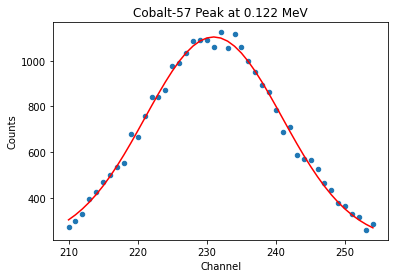

In [15]:
A = 1000
B = 230
C = 10
D = 150

cobalt57_peak_1 = cobalt57.iloc[210:255].copy()
ax1 = cobalt57_peak_1.plot.scatter(cobalt57_peak_1.columns[0], cobalt57_peak_1.columns[1])
ax1.set_title("Cobalt-57 Peak at 0.122 MeV")

xdata_Co = cobalt57_peak_1.iloc[:,0].values
ydata_Co = cobalt57_peak_1.iloc[:,1].values

cobalt57_peak_1_values = find_values(A, B, C, D, xdata_Co, ydata_Co)

sigma_amp, sigma_mean, sigma_std, sigma_b = find_uncertainties(cobalt57_peak_1_values)


Optimized Parameters:
[Amplitude, Mean, Sigma, Vertical Offset]
Amplitude: 82.88, Mean: 1292.94, Sigma: 33.01, y_offset: 3.16

Uncertainty in amplitude: 2.25, Uncertainty in mean: 0.45
Sigma standard deviation: 1.17, Uncertainty in y offset: 2.42


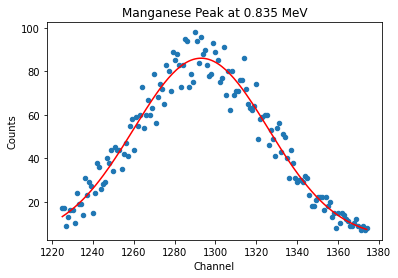

In [16]:
A = 100
B = 1280
C = 30
D = 20

manganese_peak_1 = manganese.iloc[1225:1375].copy()
ax1 = manganese_peak_1.plot.scatter(manganese_peak_1.columns[0], manganese_peak_1.columns[1])
ax1.set_title("Manganese Peak at 0.835 MeV")

xdata_Mn = manganese_peak_1.iloc[:,0].values
ydata_Mn = manganese_peak_1.iloc[:,1].values

manganese_peak_1_values = find_values(A, B, C, D, xdata_Mn, ydata_Mn)

sigma_amp, sigma_mean, sigma_std, sigma_b = find_uncertainties(manganese_peak_1_values)

# Testing the unknown data

We are approaching the final step. We have gathered data on either sides of the range that our element's gamma radiation peaked in. The data that we have should be enough to create a line which can associate known energy values to the data channels that were struck in our detector, with a margin of error.


Optimized Parameters:
[Amplitude, Mean, Sigma, Vertical Offset]
Amplitude: 3674.52, Mean: 1056.87, Sigma: 28.56, y_offset: 105.10

Uncertainty in amplitude: 42.36, Uncertainty in mean: 0.09
Sigma standard deviation: 0.35, Uncertainty in y offset: 46.02

Optimized Parameters:
[Amplitude, Mean, Sigma, Vertical Offset]
Amplitude: 19.01, Mean: 1630.79, Sigma: 35.83, y_offset: 6.56

Uncertainty in amplitude: 1.24, Uncertainty in mean: 1.28
Sigma standard deviation: 3.17, Uncertainty in y offset: 1.33


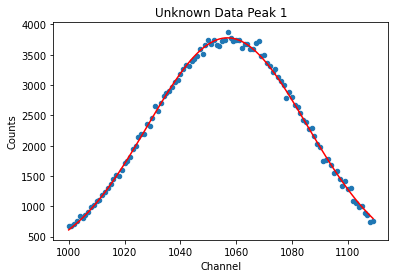

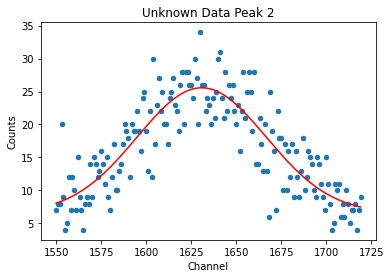

In [17]:
A = 3500
B = 1060
C = 50
D = 400


unknown_peak_1 = unknown.iloc[1000:1110].copy()
ax1 = unknown_peak_1.plot.scatter(unknown_peak_1.columns[0], unknown_peak_1.columns[1])
ax1.set_title("Unknown Data Peak 1")

xdata1_unk = unknown_peak_1.iloc[:,0].values
ydata1_unk = unknown_peak_1.iloc[:,1].values

unknown_peak_1_values = find_values(A, B, C, D, xdata1_unk, ydata1_unk)
unk_peak_1_sigma = unknown_peak_1_values[2]

sigma_amp, uncertainties_1_sigma_mean, sigma_std, sigma_b = find_uncertainties(unknown_peak_1_values)

A = 20
B = 1630
C = 5
D = 5

unknown_peak_2 = unknown.iloc[1550:1720].copy()
ax1 = unknown_peak_2.plot.scatter(unknown_peak_2.columns[0], unknown_peak_2.columns[1])
ax1.set_title("Unknown Data Peak 2")

xdata2_unk = unknown_peak_2.iloc[:,0].values
ydata2_unk = unknown_peak_2.iloc[:,1].values

unknown_peak_2_values = find_values(A, B, C, D, xdata2_unk, ydata2_unk)
unk_peak_2_sigma = unknown_peak_2_values[2]

sigma_amp, uncertainties_2_sigma_mean, sigma_std, sigma_b = find_uncertainties(unknown_peak_2_values)

Unknown 1 channel count: 1056.87
Unknown 2 channel count: 1630.79
Unknown 1 predicted value: 695.64
Unknown 2 predicted value: 1099.89


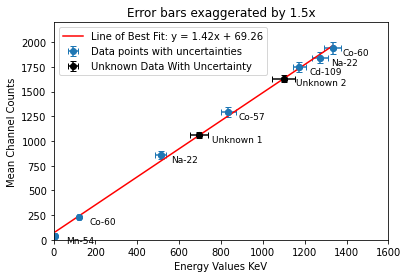

In [18]:
from scipy.stats import linregress

# Storing found values
value_bank = {
    (cobalt_peak_1_values, 1175), 
    (cobalt_peak_2_values, 1333),
    (sodium_peak_1_values, 511),
    (sodium_peak_2_values, 1274.5),
    (cadmium_peak_1_values, 8.8),
    (cobalt57_peak_1_values, 122),
    (manganese_peak_1_values, 835),
    (unknown_peak_1_values, None),
    (unknown_peak_2_values, None)
}

tested_means    = []
sigma_values    = []
known_means     = []
 
sigma_amp_list  = []
sigma_mean_list = []
sigma_std_list  = []
sigma_b_list    = []

for (tested, known) in value_bank:
    if known is None:
        pass
    else:
        # sigma_amp, sigma_mean, sigma_std, sigma_b
        uncertainties = find_uncertainties(tested)

        tested_means.append(tested[1])
        sigma_values.append(1.5 * tested[2])
        known_means.append(known)
        
        sigma_amp_list.append(uncertainties[0])
        sigma_mean_list.append(uncertainties[1])
        sigma_std_list.append(uncertainties[2])
        sigma_b_list.append(uncertainties[3])        

# Calculating equation of line with swapped axes
slope, intercept, r_value, p_value, std_err = linregress(known_means, tested_means)

# Plotting unknown element with swapped axes
unk_1_yvalue = unknown_peak_1_values[1]
unk_2_yvalue = unknown_peak_2_values[1]
print(f'Unknown 1 channel count: {unk_1_yvalue:.2f}')
print(f'Unknown 2 channel count: {unk_2_yvalue:.2f}')

# y = mx +b
# x = (y-b)/m
unk_1_predicted_value = (unk_1_yvalue - intercept)/slope
unk_2_predicted_value = (unk_2_yvalue - intercept)/slope
print(f'Unknown 1 predicted value: {unk_1_predicted_value:.2f}')
print(f'Unknown 2 predicted value: {unk_2_predicted_value:.2f}')

# Labelling data
data_labels = ['Co-60','Co-60','Na-22','Na-22',
               'Cd-109','Co-57','Mn-54']
for x, y, label in zip(known_means, tested_means, data_labels):
    plt.text(x+50, y, label, fontsize=9, ha='left', va='top')
    
unknown_labels = ['Unknown 1','Unknown 2']
for x, y, label in zip([unk_1_predicted_value , unk_2_predicted_value ], [unk_1_yvalue, unk_2_yvalue], unknown_labels):
    plt.text(x+60, y, label, fontsize=9, ha='left', va='top')

# Errors (y should be tested_means, x should be known_means)
x_err = np.array([sigma / abs(slope) for sigma in sigma_values])
y_err = sigma_values

# Create the line using known_means as the x-axis
x_line = np.linspace(min(known_means), max(known_means), 100)
y_line = slope * x_line + intercept

# Plotting with correct axes
plt.errorbar(known_means, tested_means, xerr=x_err, yerr=y_err, 
             fmt='o', label="Data points with uncertainties", capsize=3)
plt.scatter(known_means, tested_means)

# Plotting unknown element data
unknown_x_err = np.array([1.5 * unk_peak_1_sigma / abs(slope), 1.5 * unk_peak_2_sigma / abs(slope)])
unknown_y_err = np.array([1.5 * unk_peak_1_sigma, 1.5 * unk_peak_2_sigma])

plt.errorbar([unk_1_predicted_value, unk_2_predicted_value], [unk_1_yvalue, unk_2_yvalue], 
             unknown_x_err, unknown_y_err, fmt='o', label="Unknown Data With Uncertainty", color='black', capsize=3)
plt.scatter([unk_1_predicted_value, unk_2_predicted_value], [unk_1_yvalue, unk_2_yvalue], color="black", marker=".", s=150)

# Plot the regression line
plt.plot(x_line, y_line, color="red", label=f"Line of Best Fit: y = {slope:.2f}x + {intercept:.2f}")

# Corrected labels for the plot
plt.xlabel('Energy Values KeV')
plt.ylabel('Mean Channel Counts')
plt.xlim(0,1600)
plt.ylim(0,2200)
plt.title('Error bars exaggerated by 1.5x')
#plt.yscale('log')
plt.legend()
plt.savefig('output_graph.png', format='png')

# Conclusions:

The mean value struck by the first peak of the unknown element was channel **1056 $\pm$ 39.36**, which corresponds to an energy range of **695.64 $\pm$ 40.23 KeV** Giving us a 2$\sigma$ range of **655.41-735.87 KeV (0.655-0.736 MeV)**

For a 4 sigma range ($\pm$ 2$\sigma$) with an associated 95% confidence interval, the energy range becomes: 

**615.18-776.1 KeV (0.615-0.776 MeV)**

The mean value struck by the second peak of the unknown element was channel **1630.79 $\pm$ 25.24**, which corresponds to an energy range of **1049.41 $\pm$ 25.24 KeV**, giving us a 2$\sigma$ range of: 

**1074.65-1125.13 KeV (1.075-1.125 MeV)**

For a 4 sigma range ($\pm$ 2$\sigma$), giving us a 95% confidence interval, the energy range becomes **998.93-1099.89 KeV (0.999-1.1 MeV)**

# Finding the element:

Using the information found at: https://web.physics.indiana.edu/courses/p451/examples/Gamma_Energies_table.pdf

The most likely candidates (with half-lives over 30 days, as this sample has been in use for multiple semesters) for the first peak are:

| $\gamma$ (KeV) | Nuclide | Half-Life |
|  ------------- | ------------- | ------------- |
| 622            | Ru-106        | 367 days      |
|658             | Ag-110m       |253 days       |
|661.64          | Cs-137        |  30 years     | 
|697             | Te-129m       | 34 days       |
|724             | Zr-95         | 65 days       |
|756             | Zr-95         | 65 days       |  
|765             | Nb-95         |  35 days      |

And the most like candidates for the second peak are:


| $\gamma$ (KeV) | Nuclide | Half-Life |
|  ------------- | ------------- | ------------- |
| 1095           | Fe-59         | 45 days       |
|1115            | Zn-65         | 245 days      |
|1120            | Sc-46         |  83.9         | 
|1122            | Ta-182        | 115 days      |

As there doesn't appear to be any overlap between the two charts, it is possible that the sample could contain two separate nuclides. The elements which are the closest to the mean value of our detected peaks could be Cs-137 or Te-129 for the first peak, or 